In [72]:
from matplotlib import pylab
import nengo
import random
import numpy as np
import gzip as gz
from cPickle import load
try:
    import Image
except ImportError:
    from PIL import Image
from scipy.sparse.linalg import svds

%matplotlib inline

In [73]:
def load_img(path, dims):
    """Load the image at path and return an array representing the raster.
    Flattens image. Shifts pixel activations such that 0 represents gray,
    normalizes the output array.
    Keyword arguments:
    path -- str, path of the image to be loaded.
    dims -- (w, h), where w,h are ints indicating dimensions of the image (in
        px)."""

    img = Image.open(path).resize(dims).getdata()
    img.convert('L')
    img = subtract(array(img).flatten(), 127.5)
    return img/norm(img)


def load_data(filename):
    """Uncompress, unpickle and return a .pkl.gz file.
    Keyword arguments:
    filename -- str, a valid file path"""

    return load(gz.open(filename))

def load_mini_mnist(option=None):
    """Load and return the first \%10 of the images in the mnist dataset.
    Does not return labels. Pass in 'train', 'valid' or 'test' if you want to
    load a specific subset of the dataset.
    Keyword arguments:
    option -- str (default=None)."""

    mini_mnist = load(gz.open('./mini_mnist.pkl.gz', 'rb'))
    if option == 'train':
        return mini_mnist[0]
    elif option == 'valid':
        return mini_mnist[1]
    elif option == 'test':
        return mini_mnist[2]
    else:
        return mini_mnist

In [74]:
conn_synapse = 0.1
probe_synapse = 0.01
multiplier = 2
n_neurons = 5000
direct = False
stop_time = 0.1
run_time = 0.2 #in seconds

In [75]:
dim = 28
mnist = load_mini_mnist()
train = mnist[0]
img = mnist[2][100]
compress_size = 400
basis, S, V = svds(train.T, k=compress_size)

In [76]:
expanded_basis = np.array([random.choice(basis.T) for _ in range(n_neurons)])

In [77]:
def stim_func(t):
    if t < stop_time:
        return img
    else:
        return [0 for _ in range(len(img))]

In [78]:
with nengo.Network() as net:
    
    if direct:
        neuron_type = nengo.Direct()
    else:
        neuron_type = nengo.LIF()        

    ipt = nengo.Node(stim_func)
    ens = nengo.Ensemble(n_neurons,
                         dimensions=dim**2,
                         encoders=expanded_basis,
                         eval_points=expanded_basis,
                         n_eval_points=n_neurons,
                         neuron_type=neuron_type)

    nengo.Connection(ipt, ens, synapse=None, transform=1)
    conn = nengo.Connection(ens, ens, synapse=conn_synapse)

    probe = nengo.Probe(ens, attr='decoded_output',
                        synapse=probe_synapse)

In [79]:
sim = nengo.Simulator(net)

In [80]:
sim.run(run_time)

Simulation finished in 0:00:03.                                                 


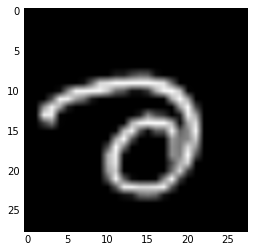

In [81]:
pylab.imshow(np.reshape(img, (dim,dim), 'F'), cmap='Greys_r')

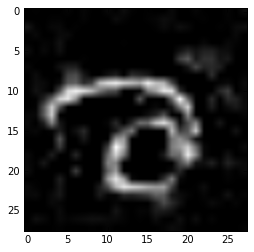

In [82]:
pylab.imshow(np.reshape([0. if x < 0.00001 else x 
                         for x in sim.data[probe][int(stop_time*1000)]], (dim, dim), 'F'), cmap='Greys_r')